In [46]:
import linopy
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely import wkt
import numpy as np

In [47]:
coarsenscale = 5
lccs_resolution = 300 * coarsenscale #m
areapergrid = (lccs_resolution/1000) ** 2 ## km2
scenario_SI = 0  ## Include area where SI >= scenario_SI

mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET

mwpergrid_wind = np.round(areapergrid * mwperkm2_wind,2)
mwpergrid_solar =  np.round(areapergrid * mwperkm2_solar,2)

suitablearea_biomass = 150 ## km2

rollingwindow_biomass = int(np.ceil(np.sqrt(suitablearea_biomass/areapergrid)))

print('areapergrid = ',areapergrid)
print('mwpergrid_wind = ',mwpergrid_wind)
print('mwpergrid_solar = ',mwpergrid_solar)
print('rollingwindow_biomass = ',rollingwindow_biomass,' * ',rollingwindow_biomass)


areapergrid =  2.25
mwpergrid_wind =  10.12
mwpergrid_solar =  33.75
rollingwindow_biomass =  9  *  9


In [48]:
xr_final_SI_raw = xr.open_dataset('Output\\xr_final_SI_all.nc')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('ADM1_EN')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('SI_BGEC')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('SI_BGWW')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('SI_MSW')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('SI_IEW')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('A_BGEC')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('A_BGWW')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('A_MSW')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('A_IEW')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('AVA_BGEC')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('AVA_BGWW')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('AVA_MSW')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('AVA_IEW')
print(xr_final_SI_raw)

<xarray.Dataset>
Dimensions:      (lat: 5346, lon: 2985)
Coordinates:
  * lat          (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon          (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables:
    lccs_class   (lat, lon) int64 ...
    SI_Biomass   (lat, lon) float64 ...
    SI_Solar     (lat, lon) float64 ...
    SI_Wind      (lat, lon) float64 ...
    A_Biomass    (lat, lon) float64 ...
    AVA_Wind     (lat, lon) float32 ...
    AVA_Solar    (lat, lon) float32 ...
    AVA_Biomass  (lat, lon) float64 ...


In [49]:
xr_final_SI_raw['SI_Wind'] = xr.where(xr_final_SI_raw['SI_Wind'] >= scenario_SI ,xr_final_SI_raw['SI_Wind'],0)
xr_final_SI_raw['AVA_Wind'] = xr.where(xr_final_SI_raw['SI_Wind'] == 0 , 0 , xr_final_SI_raw['AVA_Wind'])

xr_final_SI_raw['SI_Solar'] = xr.where(xr_final_SI_raw['SI_Solar'] >= scenario_SI ,xr_final_SI_raw['SI_Solar'],0)
xr_final_SI_raw['AVA_Solar'] = xr.where(xr_final_SI_raw['SI_Solar'] == 0 , 0 , xr_final_SI_raw['AVA_Solar'])

xr_final_SI_raw['SI_Biomass'] = xr.where(xr_final_SI_raw['SI_Biomass'] >= scenario_SI ,xr_final_SI_raw['SI_Biomass'],0)
xr_final_SI_raw['AVA_Biomass'] = xr.where(xr_final_SI_raw['SI_Biomass'] == 0 , 0 , xr_final_SI_raw['AVA_Biomass'])

In [50]:
xr_final_SI = xr_final_SI_raw.coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').sum()
xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] / (coarsenscale**2)
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] / (coarsenscale**2)
xr_final_SI['SI_Biomass'] = xr_final_SI['SI_Biomass'] / (coarsenscale**2)

######### Find min/max SI within cell #############
# xr_final_SI['SI_Wind_max'] = xr_final_SI_raw['SI_Wind'].coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').max()
# xr_final_SI['SI_Wind_min'] = xr_final_SI_raw['SI_Wind'].coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').min()
# xr_final_SI['SI_Solar_max'] = xr_final_SI_raw['SI_Solar'].coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').max()
# xr_final_SI['SI_Solar_min'] = xr_final_SI_raw['SI_Solar'].coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').min()
# xr_final_SI['SI_Biomass_max'] = xr_final_SI_raw['SI_Biomass'].coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').max()
# xr_final_SI['SI_Biomass_min'] = xr_final_SI_raw['SI_Biomass'].coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').min()

xr_final_SI_raw.close()
print(xr_final_SI.data_vars)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print("A_Biomass = ",xr_final_SI['A_Biomass'].sum())
print('Max SI_Wind = ',xr_final_SI['SI_Wind'].max())
print('Max SI_Solar = ',xr_final_SI['SI_Solar'].max())
print('Max SI_Biomass = ',xr_final_SI['SI_Biomass'].max())


Data variables:
    lccs_class   (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SI_Biomass   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    A_Biomass    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar    (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Biomass  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(66376.44, dtype=float32)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(69483.79, dtype=float32)
A_Biomass =  <xarray.DataArray 'A_Biomass' ()>
array(16032.17194298)
Max SI_Wind =  <xarray.DataArray 'SI_Wind' ()>
array(2.56912345)
Max SI_Solar =  <xarray.DataArray 'SI_Solar' ()>
array(2

In [51]:
######### Next I assign Region to xarray ################################################################################

region = pd.read_csv('Data\\Region.csv',index_col=False)
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')

thailandmap.crs = {'init': 'epsg:4326'}
list_region = []

count = 0
for i in thailandmap['ADM1_TH']:
    r = region['region'].loc[region['province'] == i]
    try : 
        # print(i,r.values[0])
        list_region.append(r.values[0])
    except :
        print(i,'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
        list_region.append('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')       
    
thailandmap['region'] = list_region
thailandmap['center'] = thailandmap['geometry'].centroid
thailandmap = thailandmap.set_geometry('center')

thailandmap = thailandmap.drop(columns=['Shape_Leng',
                                        'Shape_Area',
                                        'ADM1_PCODE',
                                        'ADM1_REF',
                                        'ADM1ALT1EN',
                                        'ADM1ALT2EN',
                                        'ADM1ALT1TH',
                                        'ADM1ALT2TH',
                                        'ADM0_EN',
                                        'ADM0_TH',
                                        'ADM0_PCODE',
                                        'date',
                                        'validOn',
                                        'validTo'
                                        ,'geometry'
                                        ])


print(thailandmap['ADM1_EN'].unique())
print(thailandmap['region'].unique())

['Bangkok' 'Samut Prakan' 'Nonthaburi' 'Pathum Thani'
 'Phra Nakhon Si Ayutthaya' 'Ang Thong' 'Lop Buri' 'Sing Buri' 'Chai Nat'
 'Saraburi' 'Chon Buri' 'Rayong' 'Chanthaburi' 'Trat' 'Chachoengsao'
 'Prachin Buri' 'Nakhon Nayok' 'Sa Kaeo' 'Nakhon Ratchasima' 'Buri Ram'
 'Surin' 'Si Sa Ket' 'Ubon Ratchathani' 'Yasothon' 'Chaiyaphum'
 'Amnat Charoen' 'Bueng Kan' 'Nong Bua Lam Phu' 'Khon Kaen' 'Udon Thani'
 'Loei' 'Nong Khai' 'Maha Sarakham' 'Roi Et' 'Kalasin' 'Sakon Nakhon'
 'Nakhon Phanom' 'Mukdahan' 'Chiang Mai' 'Lamphun' 'Lampang' 'Uttaradit'
 'Phrae' 'Nan' 'Phayao' 'Chiang Rai' 'Mae Hong Son' 'Nakhon Sawan'
 'Uthai Thani' 'Kamphaeng Phet' 'Tak' 'Sukhothai' 'Phitsanulok' 'Phichit'
 'Phetchabun' 'Ratchaburi' 'Kanchanaburi' 'Suphan Buri' 'Nakhon Pathom'
 'Samut Sakhon' 'Samut Songkhram' 'Phetchaburi' 'Prachuap Khiri Khan'
 'Nakhon Si Thammarat' 'Krabi' 'Phangnga' 'Phuket' 'Surat Thani' 'Ranong'
 'Chumphon' 'Songkhla' 'Satun' 'Trang' 'Phatthalung' 'Pattani' 'Yala'
 'Narathiwat']
['R0' 'R1

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_16712\1503556515.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  thailandmap['center'] = thailandmap['geometry'].centroid


In [52]:
df_final_SI = xr_final_SI.to_dataframe()
df_final_SI.reset_index(inplace=True)
df_final_SI = gpd.GeoDataFrame(df_final_SI, geometry =gpd.points_from_xy(df_final_SI['lon'],df_final_SI['lat']))
df_final_SI.crs = {'init': 'epsg:4326'}
df_final_SI.reset_index(inplace= True, drop = False)
print(df_final_SI.columns)

df_final_SI_2 = gpd.sjoin_nearest(df_final_SI,thailandmap,how = 'left')
df_final_SI_2 = df_final_SI_2.drop(columns=['ADM1_TH','geometry','index_right'])

df_final_SI_2 = df_final_SI_2.drop_duplicates('index')
df_final_SI_2 = df_final_SI_2.drop(columns=['index'])

df_final_SI_2.reset_index(inplace= True, drop = True)
df_final_SI_2 = df_final_SI_2.set_index(['lat', 'lon'])
print(df_final_SI_2)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Index(['index', 'lat', 'lon', 'lccs_class', 'SI_Biomass', 'SI_Solar',
       'SI_Wind', 'A_Biomass', 'AVA_Wind', 'AVA_Solar', 'AVA_Biomass',
       'geometry'],
      dtype='object')
                      lccs_class  SI_Biomass  SI_Solar  SI_Wind  A_Biomass  \
lat       lon                                                                
5.620833  97.351389            0         0.0       0.0      0.0        0.0   
          97.365278            0         0.0       0.0      0.0        0.0   
          97.379167            0         0.0       0.0      0.0        0.0   
          97.393056            0         0.0       0.0      0.0        0.0   
          97.406944            0         0.0       0.0      0.0        0.0   
...                          ...         ...       ...      ...        ...   
20.454167 105.573611           0         0.0       0.0      0.0        0.0   
          105.587500           0         0.0       0.0      0.0        0.0   
          105.601389           0     

In [53]:
xr_final_SI = xr.Dataset.from_dataframe(df_final_SI_2)
print(xr_final_SI)

<xarray.Dataset>
Dimensions:      (lat: 1069, lon: 597)
Coordinates:
  * lat          (lat) float64 5.621 5.635 5.649 5.663 ... 20.43 20.44 20.45
  * lon          (lon) float64 97.35 97.37 97.38 97.39 ... 105.6 105.6 105.6
Data variables:
    lccs_class   (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SI_Biomass   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    A_Biomass    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar    (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Biomass  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN      (lat, lon) object 'Phuket' 'Phuket' ... 'Bueng Kan' 'Bueng Kan'
    region       (lat, lon) object 'R3' 

################################### NOW ITS AN OPTIMIZATION TIME !!!!!! ##############################################################################

In [54]:
## xr_ref = xr.open_dataset('Output\\xr_final_SI_preped.nc')
xr_ref = xr_final_SI
print("AVA Wind = ",xr_ref['AVA_Wind'].sum())
print("AVA Solar = ",xr_ref['AVA_Solar'].sum()) 
print("A_Biomass = ",xr_ref['A_Biomass'].sum())
print('Mean SI Wind = ',xr_ref['SI_Wind'].where(xr_ref['SI_Wind']>0).mean())
print('Mean SI Solar = ',xr_ref['SI_Solar'].where(xr_ref['SI_Solar']>0).mean())
print('Mean SI_Biomass = ',xr_ref['SI_Biomass'].where(xr_ref['SI_Biomass']>0).mean())
print('Max SI Wind = ',xr_ref['SI_Wind'].max())
print('Max SI Solar = ',xr_ref['SI_Solar'].max())
print('Max SI Biomass = ',xr_ref['SI_Biomass'].max())
print('coarsenscale = ',coarsenscale)
print('areapergrid = ',areapergrid)
print('mwpergrid_wind = ',mwpergrid_wind)
print('mwpergrid_solar = ',mwpergrid_solar)

######## PDP ############################################################
quota_wind_total =  0
quota_wind_R0 = 0
quota_wind_R1 = 0
quota_wind_R2 = 0
quota_wind_R3 =  0
quota_wind_R4 =  0

quota_solar_total =  0
quota_solar_R0 =  0
quota_solar_R1 =  0
quota_solar_R2 =  0
quota_solar_R3 = 0
quota_solar_R4 =  0

quota_biomass_total = 0
quota_biomass_R0 = 0
quota_biomass_R1 =  0
quota_biomass_R2 =  0
quota_biomass_R3 =   0
quota_biomass_R4 =  0
######## PDP ############################################################

# ######## PDP ############################################################
# quota_wind_total =  6335
# quota_wind_R0 = 0
# quota_wind_R1 = 0
# quota_wind_R2 = 6075
# quota_wind_R3 =  260
# quota_wind_R4 =  0

# quota_solar_total =  24182
# quota_solar_R0 =  16
# quota_solar_R1 =  4133
# quota_solar_R2 =  4989
# quota_solar_R3 = 8825
# quota_solar_R4 =  6219

# quota_biomass_total = 1010
# quota_biomass_R0 = 0
# quota_biomass_R1 =  213
# quota_biomass_R2 =  361
# quota_biomass_R3 =   90
# quota_biomass_R4 =  346
# ######## PDP ############################################################'

AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(66376.44, dtype=float32)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(69483.79, dtype=float32)
A_Biomass =  <xarray.DataArray 'A_Biomass' ()>
array(16032.17194298)
Mean SI Wind =  <xarray.DataArray 'SI_Wind' ()>
array(0.61670405)
Mean SI Solar =  <xarray.DataArray 'SI_Solar' ()>
array(0.87354589)
Mean SI_Biomass =  <xarray.DataArray 'SI_Biomass' ()>
array(0.95830356)
Max SI Wind =  <xarray.DataArray 'SI_Wind' ()>
array(2.56912345)
Max SI Solar =  <xarray.DataArray 'SI_Solar' ()>
array(2.71569582)
Max SI Biomass =  <xarray.DataArray 'SI_Biomass' ()>
array(2.80996035)
coarsenscale =  5
areapergrid =  2.25
mwpergrid_wind =  10.12
mwpergrid_solar =  33.75


In [55]:
######################## model #####################################################
m = linopy.Model()

built_wind = m.add_variables(binary=True, coords=xr_ref.coords, name='built_wind')
cap_wind = m.add_variables(lower=0.00, coords=xr_ref.coords, name='cap_wind')

built_solar = m.add_variables(binary=True, coords=xr_ref.coords, name='built_solar')
cap_solar = m.add_variables(lower=0.00, coords=xr_ref.coords, name='cap_solar')

built_biomass = m.add_variables(binary=True, coords=xr_ref.coords, name='built_biomass')
cap_biomass = m.add_variables(lower=0.00, coords=xr_ref.coords, name='cap_biomass')


############################################ Constraint Building Location Logic ##############################################################################
constr_built_logic =  m.add_constraints(
    (
        built_wind
        +
        built_solar
        +
        built_biomass.rolling(lat = rollingwindow_biomass,min_periods=1,center=True).sum().rolling(lon = rollingwindow_biomass,min_periods=1,center=True).sum()
    )
        <= 1
        , name='constr_built_logic'
)

############################################ Constraint Building Location Logic ##############################################################################

############################################ Constraint Capacity ##############################################################################
constr_maxcap_wind = m.add_constraints(
    cap_wind <= (built_wind) * xr_ref['AVA_Wind'] * mwperkm2_wind
    ,name = 'constr_maxcap_wind'
)
constr_mincap_wind = m.add_constraints(
    cap_wind >= (built_wind) * 1
    ,name = 'constr_mincap_wind'
)
constr_builtarea_wind = m.add_constraints(
    built_wind <= xr_ref['AVA_Wind'] * 10000
    ,name = 'constr_builtarea_wind'
)

constr_maxcap_solar = m.add_constraints(
    cap_solar <= (built_solar) * xr_ref['AVA_Solar'] * mwperkm2_solar
    ,name = 'constr_maxcap_solar'
)
constr_mincap_solar = m.add_constraints(
    cap_solar >= (built_solar) * 1
    ,name = 'constr_mincap_solar'
)
constr_builtarea_solar = m.add_constraints(
    built_solar <= xr_ref['AVA_Solar'] * 10000
    ,name = 'constr_builtarea_solar'
)

constr_maxcap_biomass = m.add_constraints(
    cap_biomass <= (built_biomass) * (xr_ref['A_Biomass'].rolling(lon = rollingwindow_biomass, lat = rollingwindow_biomass, min_periods=1,center=True).sum() )
    ,name = 'constr_maxcap_biomass'
)
constr_mincap_biomass = m.add_constraints(
    cap_biomass >= (built_biomass) * 1
    ,name = 'constr_mincap_biomass'
)
constr_builtarea_biomass = m.add_constraints(
    built_biomass <= xr_ref['AVA_Biomass'] * 10000
    ,name = 'constr_builtarea_biomass'
)
############################################ Constraint Capacity ##############################################################################

# ###########################################################################################################################################################

# constr_quota_wind = m.add_constraints((cap_wind.sum()) >= quota_wind_total , name='constr_quota_wind')

# constr_quota_wind_r0 = m.add_constraints(lhs = (cap_wind).where((xr_ref['region'] == 'R0'),drop=True).sum()
#                                              , sign = '>=' , rhs = quota_wind_R0, name='constr_quota_wind_r0')

# constr_quota_wind_r1 = m.add_constraints(lhs = (cap_wind).where((xr_ref['region'] == 'R1'),drop=True).sum()
#                                              , sign = '>=' , rhs = quota_wind_R1, name='constr_quota_wind_r1')

# constr_quota_wind_r2 = m.add_constraints(lhs = (cap_wind).where((xr_ref['region'] == 'R2'),drop=True).sum()
#                                              , sign = '>=' , rhs = quota_wind_R2, name='constr_quota_wind_r2')

# constr_quota_wind_r3 = m.add_constraints(lhs = (cap_wind).where((xr_ref['region'] == 'R3'),drop=True).sum()
#                                              , sign = '>=' , rhs = quota_wind_R3, name='constr_quota_wind_r3')

# constr_quota_wind_r4 = m.add_constraints(lhs = (cap_wind).where((xr_ref['region'] == 'R4'),drop=True).sum()
#                                              , sign = '>=' , rhs = quota_wind_R4, name='constr_quota_wind_r4')

# ############################################################################################################################################################

# constr_quota_solar = m.add_constraints((cap_solar.sum()) >= quota_solar_total, name='constr_quota_solar')

# constr_quota_solar_r0 = m.add_constraints(lhs = (cap_solar).where((xr_ref['region'] == 'R0'),drop=True).sum()
#                                              , sign = '>=' , rhs = quota_solar_R0, name='constr_quota_solar_r0')

# constr_quota_solar_r1 = m.add_constraints(lhs = (cap_solar).where((xr_ref['region'] == 'R1'),drop=True).sum()
#                                              , sign = '>=' , rhs = quota_solar_R1, name='constr_quota_solar_r1')

# constr_quota_solar_r2 = m.add_constraints(lhs = (cap_solar).where((xr_ref['region'] == 'R2'),drop=True).sum()
#                                              , sign = '>=' , rhs = quota_solar_R2, name='constr_quota_solar_r2')

# constr_quota_solar_r3 = m.add_constraints(lhs = (cap_solar).where((xr_ref['region'] == 'R3'),drop=True).sum()
#                                              , sign = '>=' , rhs = quota_solar_R3, name='constr_quota_solar_r3')

# constr_quota_solar_r4 = m.add_constraints(lhs = (cap_solar).where((xr_ref['region'] == 'R4'),drop=True).sum()
#                                              , sign = '>=' , rhs = quota_solar_R4, name='constr_quota_solar_r4')

# ###########################################################################################################################################################

# constr_quota_biomass = m.add_constraints((cap_biomass.sum()) >= quota_biomass_total, name='constr_quota_biomass')

# constr_quota_biomass_r0 = m.add_constraints(lhs = (cap_biomass).where((xr_ref['region'] == 'R0'),drop=True).sum()
#                                              , sign = '>=' , rhs = quota_biomass_R0, name='constr_quota_biomass_r0')

# constr_quota_biomass_r1 = m.add_constraints(lhs = (cap_biomass).where((xr_ref['region'] == 'R1'),drop=True).sum()
#                                              , sign = '>=' , rhs = quota_biomass_R1, name='constr_quota_biomass_r1')

# constr_quota_biomass_r2 = m.add_constraints(lhs = (cap_biomass).where((xr_ref['region'] == 'R2'),drop=True).sum()
#                                              , sign = '>=' , rhs = quota_biomass_R2, name='constr_quota_biomass_r2')

# constr_quota_biomass_r3 = m.add_constraints(lhs = (cap_biomass).where((xr_ref['region'] == 'R3'),drop=True).sum()
#                                              , sign = '>=' , rhs = quota_biomass_R3, name='constr_quota_biomass_r3')

# constr_quota_biomass_r4 = m.add_constraints(lhs = (cap_biomass).where((xr_ref['region'] == 'R4'),drop=True).sum()
#                                              , sign = '>=' , rhs = quota_biomass_R4, name='constr_quota_biomass_r4')

###########################################################################################################################################################

In [56]:
obj = (-1000) * (

    ( xr_ref['SI_Wind'] * (cap_wind) / (xr_ref['AVA_Wind'] * mwperkm2_wind) )
    +
    ( xr_ref['SI_Solar'] * (cap_solar) / (xr_ref['AVA_Solar'] * mwperkm2_solar) )
    +
    ( 
        xr_ref['SI_Biomass'].rolling(lon = rollingwindow_biomass, lat = rollingwindow_biomass, min_periods=1,center=True).sum() 
        * (cap_biomass/xr_ref['A_Biomass'].rolling(lon = rollingwindow_biomass, lat = rollingwindow_biomass, min_periods=1,center=True).sum())
     )
)

m.add_objective(obj)

In [57]:
print("presolve = ",m)
m.solve(solver_name='highs',
        # mip_abs_gap = 0.1,
        # mip_rel_gap = 0.1,
        )

print('aftersolve = ',m)
solution = m.solution
solution = solution.fillna(0)
print(solution)

presolve =  Linopy MILP model

Variables:
----------
 * built_wind (lat, lon)
 * cap_wind (lat, lon)
 * built_solar (lat, lon)
 * cap_solar (lat, lon)
 * built_biomass (lat, lon)
 * cap_biomass (lat, lon)

Constraints:
------------
 * constr_built_logic (lat, lon)
 * constr_maxcap_wind (lat, lon)
 * constr_mincap_wind (lat, lon)
 * constr_builtarea_wind (lat, lon)
 * constr_maxcap_solar (lat, lon)
 * constr_mincap_solar (lat, lon)
 * constr_builtarea_solar (lat, lon)
 * constr_maxcap_biomass (lat, lon)
 * constr_mincap_biomass (lat, lon)
 * constr_builtarea_biomass (lat, lon)

Status:
-------
initialized


Writing binary variables.: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


In [ ]:
xr_ref['cap_wind'] = np.round(solution['cap_wind'] * solution['built_wind'],3)
xr_ref['cap_solar'] = np.round(solution['cap_solar'] * solution['built_solar'],3)
xr_ref['cap_biomass'] = np.round(solution['cap_biomass'] * solution['built_biomass'],3)

print("cap_wind = ",xr_ref['cap_wind'].sum())
print("  R0 cap_wind = ",xr_ref['cap_wind'].where(xr_ref['region'] == 'R0').sum())
print("  R1 cap_wind = ",xr_ref['cap_wind'].where(xr_ref['region'] == 'R1').sum())
print("  R2 cap_wind = ",xr_ref['cap_wind'].where(xr_ref['region'] == 'R2').sum())
print("  R3 cap_wind = ",xr_ref['cap_wind'].where(xr_ref['region'] == 'R3').sum())
print("  R4 cap_wind = ",xr_ref['cap_wind'].where(xr_ref['region'] == 'R4').sum())

print("cap_solar = ",xr_ref['cap_solar'].sum())
print("  R0 cap_solar = ",xr_ref['cap_solar'].where(xr_ref['region'] == 'R0').sum())
print("  R1 cap_solar = ",xr_ref['cap_solar'].where(xr_ref['region'] == 'R1').sum())
print("  R2 cap_solar = ",xr_ref['cap_solar'].where(xr_ref['region'] == 'R2').sum())
print("  R3 cap_solar = ",xr_ref['cap_solar'].where(xr_ref['region'] == 'R3').sum())
print("  R4 cap_solar = ",xr_ref['cap_solar'].where(xr_ref['region'] == 'R4').sum())

print("cap_biomass = ",xr_ref['cap_biomass'].sum())
print("  R0 cap_biomass = ",xr_ref['cap_biomass'].where(xr_ref['region'] == 'R0').sum())
print("  R1 cap_biomass = ",xr_ref['cap_biomass'].where(xr_ref['region'] == 'R1').sum())
print("  R2 cap_biomass = ",xr_ref['cap_biomass'].where(xr_ref['region'] == 'R2').sum())
print("  R3 cap_biomass = ",xr_ref['cap_biomass'].where(xr_ref['region'] == 'R3').sum())
print("  R4 cap_biomass = ",xr_ref['cap_biomass'].where(xr_ref['region'] == 'R4').sum())

print(xr_ref.data_vars)
xr_ref.to_netcdf(path='Output\\xr_output_all_scenario_SI_' + str(scenario_SI) + '_.nc')

cap_wind =  <xarray.DataArray 'cap_wind' ()>
array(165.645)
  R0 cap_wind =  <xarray.DataArray 'cap_wind' ()>
array(0.)
  R1 cap_wind =  <xarray.DataArray 'cap_wind' ()>
array(5.265)
  R2 cap_wind =  <xarray.DataArray 'cap_wind' ()>
array(81.)
  R3 cap_wind =  <xarray.DataArray 'cap_wind' ()>
array(79.38)
  R4 cap_wind =  <xarray.DataArray 'cap_wind' ()>
array(0.)
cap_solar =  <xarray.DataArray 'cap_solar' ()>
array(289403.55)
  R0 cap_solar =  <xarray.DataArray 'cap_solar' ()>
array(1836.)
  R1 cap_solar =  <xarray.DataArray 'cap_solar' ()>
array(59999.4)
  R2 cap_solar =  <xarray.DataArray 'cap_solar' ()>
array(160386.75)
  R3 cap_solar =  <xarray.DataArray 'cap_solar' ()>
array(9522.9)
  R4 cap_solar =  <xarray.DataArray 'cap_solar' ()>
array(57658.5)
cap_biomass =  <xarray.DataArray 'cap_biomass' ()>
array(10687.379)
  R0 cap_biomass =  <xarray.DataArray 'cap_biomass' ()>
array(28.766)
  R1 cap_biomass =  <xarray.DataArray 'cap_biomass' ()>
array(2528.777)
  R2 cap_biomass =  <xarr

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


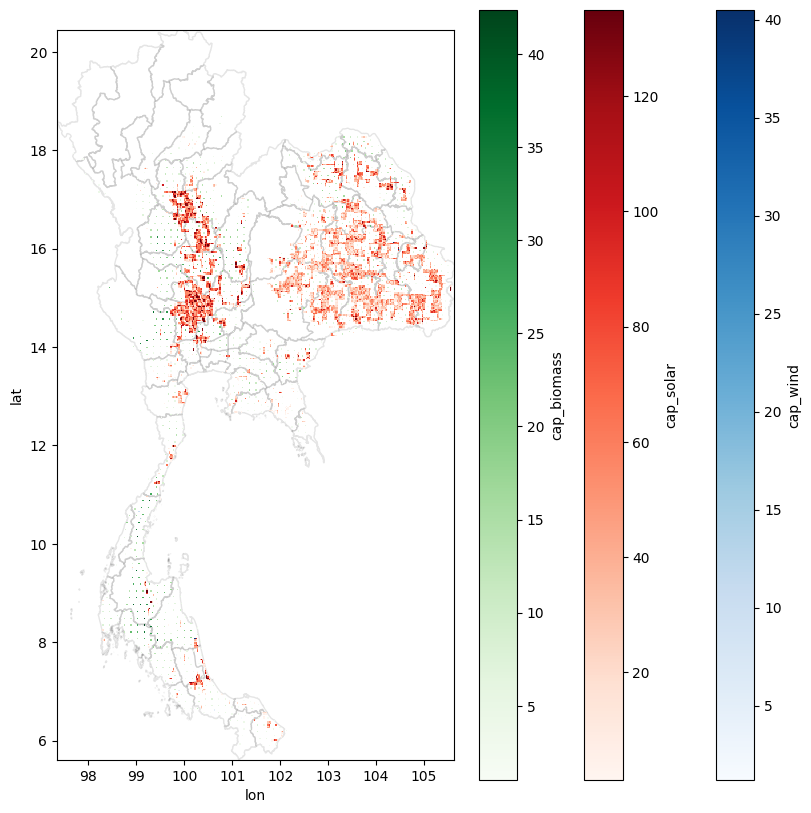

In [ ]:
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}

fig, ax = plt.subplots(figsize=(10,10))
thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0,alpha = 0.1)
xr_ref['cap_wind'].where(xr_ref['cap_wind']>0).plot(ax = ax,zorder = 1,cmap="Blues")
xr_ref['cap_solar'].where(xr_ref['cap_solar']>0).plot(ax = ax,zorder = 2,cmap="Reds")
xr_ref['cap_biomass'].where(xr_ref['cap_biomass']>0).plot(ax = ax,zorder = 3,cmap="Greens")


(101.74962536000004, 15.63262508400004, 103.18446939800003, 17.08820429900004)


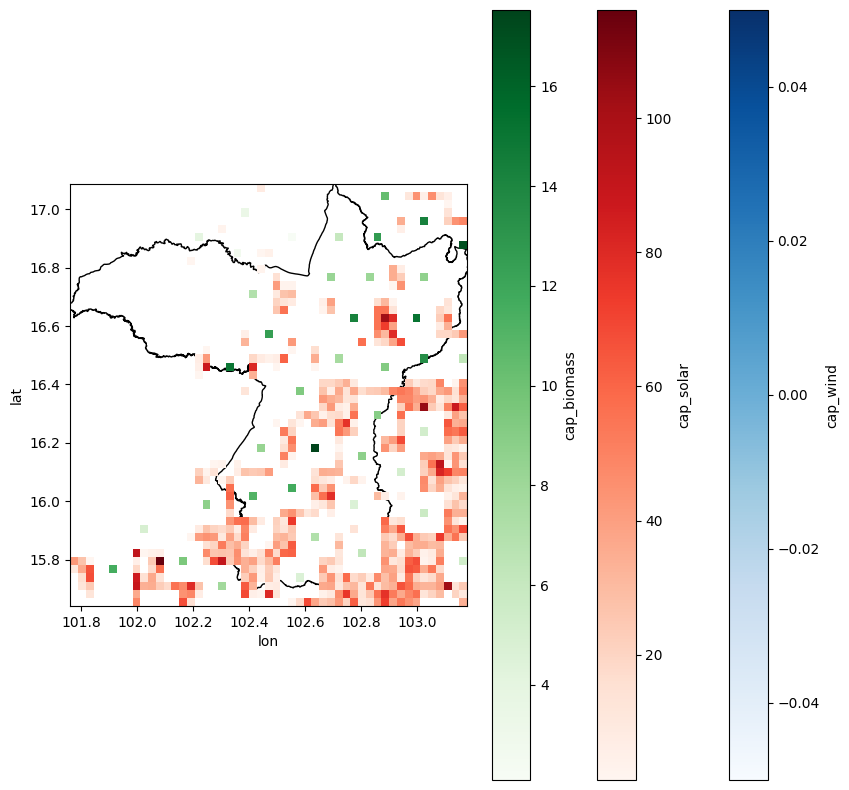

In [ ]:
province = "Khon Kaen"
province = thailandmap.loc[thailandmap['ADM1_EN'] == province]
print(province.unary_union.bounds)
min_lon = province.unary_union.bounds[0]
max_lon = province.unary_union.bounds[2]
max_lat = province.unary_union.bounds[3]
min_lat = province.unary_union.bounds[1]

xr_buffer = xr_ref.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
# print(xr_buffer)

fig, ax = plt.subplots(figsize=(10,10))
province.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
xr_buffer['cap_wind'].where(xr_buffer['cap_wind']>0).plot(ax = ax,zorder = 1,cmap="Blues")
xr_buffer['cap_solar'].where(xr_buffer['cap_solar']>0).plot(ax = ax,zorder = 2,cmap="Reds")
xr_buffer['cap_biomass'].where(xr_buffer['cap_biomass']>0).plot(ax = ax,zorder = 3,cmap="Greens")
